<a href="https://colab.research.google.com/github/salim-hbk/ai-ml/blob/main/Mnist_Siamese_Network_mnist_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random
from tensorflow.keras.datasets import mnist

In [2]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
train_x.shape

(60000, 28, 28)

In [4]:
train_x = train_x.astype('float32')
test_x = test_x.astype('float32')
train_x = train_x/255.
test_x = test_x/255.

In [5]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)

def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y


def show_image(image):
    plt.figure()
    plt.imshow(image, cmap='gray_r')
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [6]:
train_pairs, train_y =  create_pairs_on_set(train_x, train_y)
test_pairs, test_y =  create_pairs_on_set(test_x, test_y)

train_pairs.shape

(108400, 2, 28, 28)

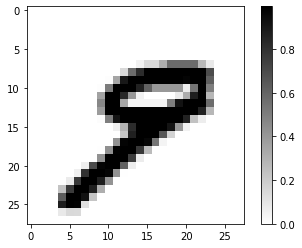

In [7]:
# array index
this_pair = 100000
show_image(train_pairs[this_pair][0])

In [8]:
def initialize_base_network():
  input = Input(shape=(28,28,1, ), name='base_network')
  x = tf.keras.layers.Conv2D(36, kernel_size=(3,3), activation='relu')(input)
  x = tf.keras.layers.Dropout(0.1)(x)
  x = tf.keras.layers.Conv2D(36, kernel_size=(3,3), activation='relu')(x)
  x = tf.keras.layers.Dropout(0.1)(x)
  x = tf.keras.layers.Flatten()(x)
  x = Dense(128, activation='relu', name='Thir_Base_Network')(x)
  output_layer= Model(inputs = input, outputs=x)
  return output_layer

def eucledean_distance(vectors):
  x, y = vectors
  distance = K.sum(K.square(x-y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(distance, K.epsilon()))

def eucledean_output_shape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)

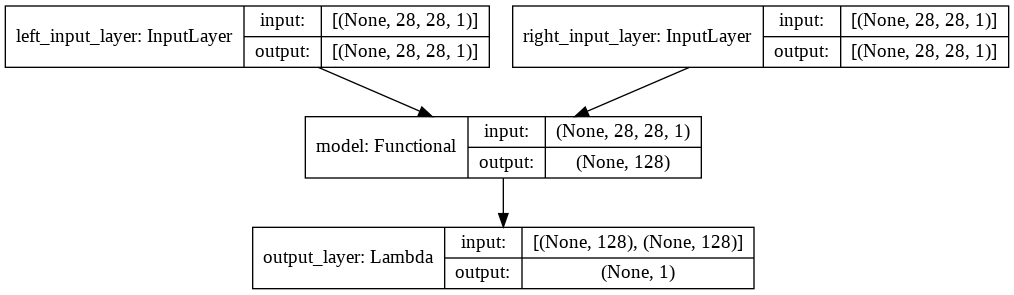

In [9]:
base_network = initialize_base_network()
input_1 = Input(shape=(28,28,1, ), name='left_input_layer')
vector_output_a = base_network(input_1)

input_2 = Input(shape=(28,28,1,), name='right_input_layer')
vector_output_b = base_network(input_2)

output_layer = Lambda(eucledean_distance, output_shape=eucledean_output_shape, name='output_layer')([vector_output_a, vector_output_b])
model = Model(inputs=[input_1, input_2], outputs=output_layer)

plot_model(model, show_shapes=True, show_layer_names=True)

In [10]:
def margin_contrastive_loss(margin):
  def contrastive_loss(y_true, y_hat):
    squared_pred= K.square(y_hat)
    margin_square = K.square(K.maximum(margin-y_hat, 0))
    return K.mean(y_true*squared_pred + (1-y_true) * margin_square)
  return contrastive_loss

In [11]:
rms = RMSprop()
model.compile(optimizer=rms, loss=margin_contrastive_loss(1))
history = model.fit([train_pairs[:,0], train_pairs[:,1]], train_y, epochs=20, batch_size=128, validation_data=([test_pairs[:,0], test_pairs[:,1]], test_y))

Epoch 1/20
847/847 [==============================] - 20s 15ms/step - loss: 0.1009 - val_loss: 0.0307
Epoch 2/20
847/847 [==============================] - 13s 15ms/step - loss: 0.0278 - val_loss: 0.0245
Epoch 3/20
847/847 [==============================] - 13s 15ms/step - loss: 0.0209 - val_loss: 0.0232
Epoch 4/20
847/847 [==============================] - 13s 15ms/step - loss: 0.0172 - val_loss: 0.0208
Epoch 5/20
847/847 [==============================] - 13s 15ms/step - loss: 0.0148 - val_loss: 0.0218
Epoch 6/20
847/847 [==============================] - 13s 15ms/step - loss: 0.0134 - val_loss: 0.0200
Epoch 7/20
847/847 [==============================] - 13s 15ms/step - loss: 0.0122 - val_loss: 0.0201
Epoch 8/20
847/847 [==============================] - 13s 15ms/step - loss: 0.0114 - val_loss: 0.0209
Epoch 9/20
847/847 [==============================] - 13s 15ms/step - loss: 0.0106 - val_loss: 0.0192
Epoch 10/20
847/847 [==============================] - 13s 15ms/step - loss: 0.010

In [12]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() > 0.5
    return np.mean(pred == y_true)

In [14]:
loss = model.evaluate(x=[test_pairs[:,0],test_pairs[:,1]], y=test_y)

y_pred_train = model.predict([train_pairs[:,0], train_pairs[:,1]])
train_accuracy = compute_accuracy(train_pairs, y_pred_train)

y_pred_test = model.predict([test_pairs[:,0], test_pairs[:,1]])
test_accuracy = compute_accuracy(test_pairs, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

557/557 [==============================] - 1s 2ms/step - loss: 0.0197


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


Loss = 0.019696451723575592, Train Accuracy = 0.0 Test Accuracy = 0.0


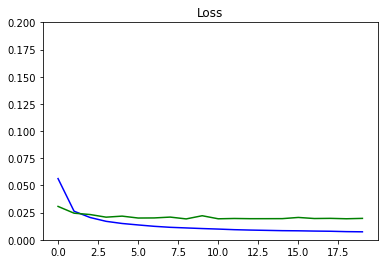

In [15]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)


In [16]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

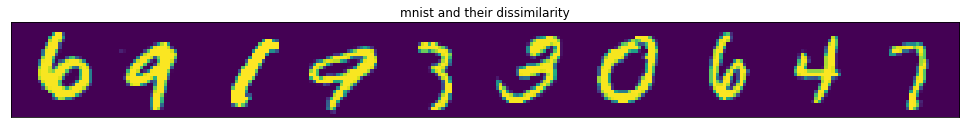

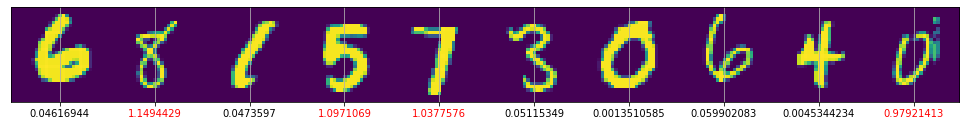

In [18]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(train_pairs[:, 0][indexes], train_pairs[:, 1][indexes], y_pred_train[indexes], train_y[indexes], "mnist and their dissimilarity", 10)